# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this project, I will execute a data analysis solution following the CRISP-DM framework. The process will involve: Data Understanding and Preparation of the 426K used car dataset from `vehicles.csv` dataset, Modeling using various regression techniques to predict price, and finally, Evaluation to interpret model coefficients. The final deliverable will be a detailed report outlining the consumer valuation factors and providing strategic recommendations to the client on maximizing inventory value.

## Load and Initial Data Exploration

Load the `vehicles.csv` dataset into a pandas DataFrame. Display its head, check data types and non-null values using `.info()`, and get descriptive statistics using `.describe()` to understand the basic structure and content of the data.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import time

df = pd.read_csv('data/vehicles.csv')

print("DataFrame Head:")
print(df.head())

print("\nDataFrame Info:")
df.info()

print("\nDataFrame Descriptive Statistics:")
print(df.describe())

DataFrame Head:
           id                  region  price  year manufacturer model  \
0  7222695916                prescott   6000   NaN          NaN   NaN   
1  7218891961            fayetteville  11900   NaN          NaN   NaN   
2  7221797935            florida keys  21000   NaN          NaN   NaN   
3  7222270760  worcester / central MA   1500   NaN          NaN   NaN   
4  7210384030              greensboro   4900   NaN          NaN   NaN   

  condition cylinders fuel  odometer title_status transmission  VIN drive  \
0       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   
1       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   
2       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   
3       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   
4       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   

  size type paint_color state  
0  NaN  NaN         NaN    az  
1  NaN  NaN       

## Data Quality Assessment

Identify and quantify missing values in each column. Investigate unique values for categorical features and assess potential inconsistencies or errors in the data that could affect analysis. Calculate the percentage of missing values for each column. Iterate through object-type columns to display unique value counts and the unique values themselves, which will help in identifying inconsistencies.


In [2]:
print("\n--- Missing Values Percentage ---\n")
missing_values = df.isnull().sum() / len(df) * 100
print(missing_values.sort_values(ascending=False))

print("\n--- Unique Values for Categorical Columns ---\n")
categorical_cols = df.select_dtypes(include='object').columns

for col in categorical_cols:
    print(f"\nColumn: {col}")
    print(f"Number of unique values: {df[col].nunique()}")
    print(f"Unique values: {df[col].unique()}")


--- Missing Values Percentage ---

size            71.767476
cylinders       41.622470
condition       40.785232
VIN             37.725356
drive           30.586347
paint_color     30.501078
type            21.752717
manufacturer     4.133714
title_status     1.930753
model            1.236179
odometer         1.030735
fuel             0.705819
transmission     0.598763
year             0.282281
region           0.000000
id               0.000000
price            0.000000
state            0.000000
dtype: float64

--- Unique Values for Categorical Columns ---


Column: region
Number of unique values: 404
Unique values: ['prescott' 'fayetteville' 'florida keys' 'worcester / central MA'
 'greensboro' 'hudson valley' 'medford-ashland' 'erie' 'el paso'
 'bellingham' 'skagit / island / SJI' 'la crosse' 'auburn' 'birmingham'
 'dothan' 'florence / muscle shoals' 'gadsden-anniston'
 'huntsville / decatur' 'mobile' 'montgomery' 'tuscaloosa'
 'anchorage / mat-su' 'fairbanks' 'kenai peninsula' 's

## Data Cleaning and Preprocessing

Handle missing values, clean and standardize categorical features, perform data type conversions, address outliers, and engineer the 'car_age' feature. Drop the 'VIN' column due to its high missing percentage and low predictive value. Drop region, as it has multiple values, and State is a better aggregated feature than region. Then, impute missing values in categorical columns with 'Unknown' and in numerical columns with their medians.


In [3]:
# model has around 30,000 unique values. Group these and consolidate to meaningful values.

# --- 1. Extract the primary model name ---
# Fill NaN models with an empty string so .str.split() works
df['model_line'] = df['model'].fillna('').astype(str).str.split().str[0]
print(f"Unique model lines after extraction: {df['model_line'].nunique()}")

# --- 2. Create Combined Manufacturer-Model Feature ---
# This makes categories like 'ford'sierra' and 'gmc'sierra' distinct
df['mfr_model_combined'] = df['manufacturer'].astype(str) + '_' + df['model_line'].astype(str)
print(f"Unique manufacturer-model combinations: {df['mfr_model_combined'].nunique()}")

# --- 3. Apply Thresholding to Combined Feature ---
N = 150  # Target: Reduce to the top 150 most common model lines (plus 'other')
high_cardinality_col = 'mfr_model_combined'

# Get the list of the top N most frequent combinations
top_N_values = df[high_cardinality_col].value_counts().nlargest(N).index

# Replace all rare combinations with a single category 'other_model'
df['mfr_model_final'] = np.where(
    df[high_cardinality_col].isin(top_N_values),
    df[high_cardinality_col],
    'other_model'
)

print(f"\nFinal unique categories in 'mfr_model_final': {df['mfr_model_final'].nunique()}")
print(f"Dropping temporary columns: {['model', 'model_line', 'mfr_model_combined']}")

# Drop the original 'model' column and the temporary columns
df = df.drop(columns=['model', 'model_line', 'mfr_model_combined'])

# The new column 'mfr_model_final' is ready for one-hot encoding!
print("\nDataFrame columns after model reduction:")
print(df.columns)

Unique model lines after extraction: 5151
Unique manufacturer-model combinations: 5985

Final unique categories in 'mfr_model_final': 151
Dropping temporary columns: ['model', 'model_line', 'mfr_model_combined']

DataFrame columns after model reduction:
Index(['id', 'region', 'price', 'year', 'manufacturer', 'condition',
       'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'VIN',
       'drive', 'size', 'type', 'paint_color', 'state', 'mfr_model_final'],
      dtype='object')


In [4]:

# 1a. Drop the 'VIN' column
df = df.drop('VIN', axis=1)
df = df.drop('region', axis=1)

# Identify categorical and numerical columns for imputation (excluding 'VIN' and 'id', 'price',)
categorical_cols = ['manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color', 'state']
numerical_cols = ['year', 'odometer']

# 1b. Impute missing values in categorical columns with the mode
for col in categorical_cols:
    if col in df.columns and df[col].isnull().any():
        mode_val = "Unknown"
        df.fillna({col: mode_val}, inplace=True)
        print(f"Imputed missing values in '{col}' with mode: {mode_val}")

# 1c. Impute missing values in numerical columns with the median
for col in numerical_cols:
    if col in df.columns and df[col].isnull().any():
        median_val = df[col].median()
        df.fillna({col: median_val}, inplace=True)
        print(f"Imputed missing values in '{col}' with median: {median_val}")

print("\nMissing values after imputation:")
print(df.isnull().sum())

Imputed missing values in 'manufacturer' with mode: Unknown
Imputed missing values in 'condition' with mode: Unknown
Imputed missing values in 'cylinders' with mode: Unknown
Imputed missing values in 'fuel' with mode: Unknown
Imputed missing values in 'title_status' with mode: Unknown
Imputed missing values in 'transmission' with mode: Unknown
Imputed missing values in 'drive' with mode: Unknown
Imputed missing values in 'size' with mode: Unknown
Imputed missing values in 'type' with mode: Unknown
Imputed missing values in 'paint_color' with mode: Unknown
Imputed missing values in 'year' with median: 2013.0
Imputed missing values in 'odometer' with median: 85548.0

Missing values after imputation:
id                 0
price              0
year               0
manufacturer       0
condition          0
cylinders          0
fuel               0
odometer           0
title_status       0
transmission       0
drive              0
size               0
type               0
paint_color        0

In [5]:

# 2. Address Outliers
initial_rows = len(df)

# a. Remove rows where 'price' is 0
df = df[df['price'] > 0]
print(f"Removed {initial_rows - len(df)} rows where 'price' was 0. Remaining rows: {len(df)}")
initial_rows = len(df)

# b. Remove rows where 'price' > 1,000,000 or 'odometer' > 1,000,000
df = df[(df['price'] <= 1_000_000) & (df['odometer'] <= 1_000_000)]
print(f"Removed {initial_rows - len(df)} rows with excessively high price or odometer. Remaining rows: {len(df)}")
initial_rows = len(df)

# c. Remove rows where 'odometer' is 0
df = df[df['odometer'] > 0]
print(f"Removed {initial_rows - len(df)} rows where 'odometer' was 0. Remaining rows: {len(df)}")


# 3. Feature Engineering - Create 'car_age'
current_year = 2025 # Using 2025 as the  recent year
df['car_age'] = current_year - df['year']

# Handle negative 'car_age' values by removing these rows
initial_rows = len(df)
df = df[df['car_age'] >= 0]
print(f"Removed {initial_rows - len(df)} rows with negative 'car_age' (indicating future or erroneous years). Remaining rows: {len(df)}")

# 4. Data Type Conversion
# a. Ensure 'year', 'odometer', and 'price' columns are of integer type
df['year'] = df['year'].astype(int)
df['odometer'] = df['odometer'].astype(int)
df['price'] = df['price'].astype(int)

# b. Convert 'cylinders' column into a numerical type
# Replace 'other' with NaN first
df['cylinders'] = df['cylinders'].replace('other', np.nan)
# Extract numerical part and convert to float, then handle remaining NaNs
df['cylinders'] = df['cylinders'].astype(str).str.extract(r'(\d+)').astype(float)
cylinders_median = df['cylinders'].median()
df['cylinders'] = df['cylinders'].fillna(cylinders_median)
df['cylinders'] = df['cylinders'].astype(int)
print(f"Converted 'cylinders' to numeric and imputed remaining NaNs with median: {cylinders_median}")


# 5. Review Cleaned Data
print("\n--- DataFrame Head after Cleaning and Preprocessing ---")
print(df.head())

print("\n--- DataFrame Info after Cleaning and Preprocessing ---")
df.info()

print("\n--- Missing values after Cleaning and Preprocessing ---")
print(df.isnull().sum())

Removed 32895 rows where 'price' was 0. Remaining rows: 393985
Removed 515 rows with excessively high price or odometer. Remaining rows: 393470
Removed 1113 rows where 'odometer' was 0. Remaining rows: 392357
Removed 0 rows with negative 'car_age' (indicating future or erroneous years). Remaining rows: 392357
Converted 'cylinders' to numeric and imputed remaining NaNs with median: 6.0

--- DataFrame Head after Cleaning and Preprocessing ---
           id  price  year manufacturer condition  cylinders     fuel  \
0  7222695916   6000  2013      Unknown   Unknown          6  Unknown   
1  7218891961  11900  2013      Unknown   Unknown          6  Unknown   
2  7221797935  21000  2013      Unknown   Unknown          6  Unknown   
3  7222270760   1500  2013      Unknown   Unknown          6  Unknown   
4  7210384030   4900  2013      Unknown   Unknown          6  Unknown   

   odometer title_status transmission    drive     size     type paint_color  \
0     85548      Unknown      Unknow

## Exploratory Data Analysis (EDA) and Visualizations

### Subtask:
Conduct a thorough EDA to understand the distribution of the target variable ('price') and key features. Utilize appropriate plots for both categorical and continuous variables (e.g., scatter plots for numerical features vs. price, box plots for categorical features vs. price). Generate correlation matrices to identify strong relationships. Ensure all plots contain readable labels, descriptive titles, legible axes, are scaled appropriately for readability, and use subplots when appropriate.


Visualize the distribution of the 'price' column using a histogram or a distribution plot to understand its spread and skewness.



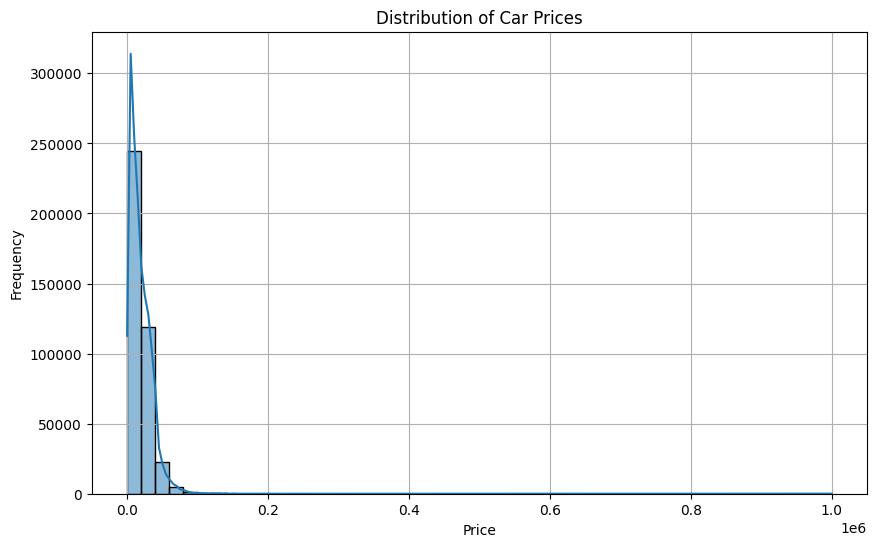

In [6]:
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], bins=50, kde=True)
plt.title('Distribution of Car Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.savefig('images/price_distribution_histogram.png')
plt.show()


Create scatter plots to visualize the relationship between 'price' and the numerical features: 'odometer', 'car_age', and 'cylinders', as specified in the instructions. This will help identify any linear or non-linear trends.



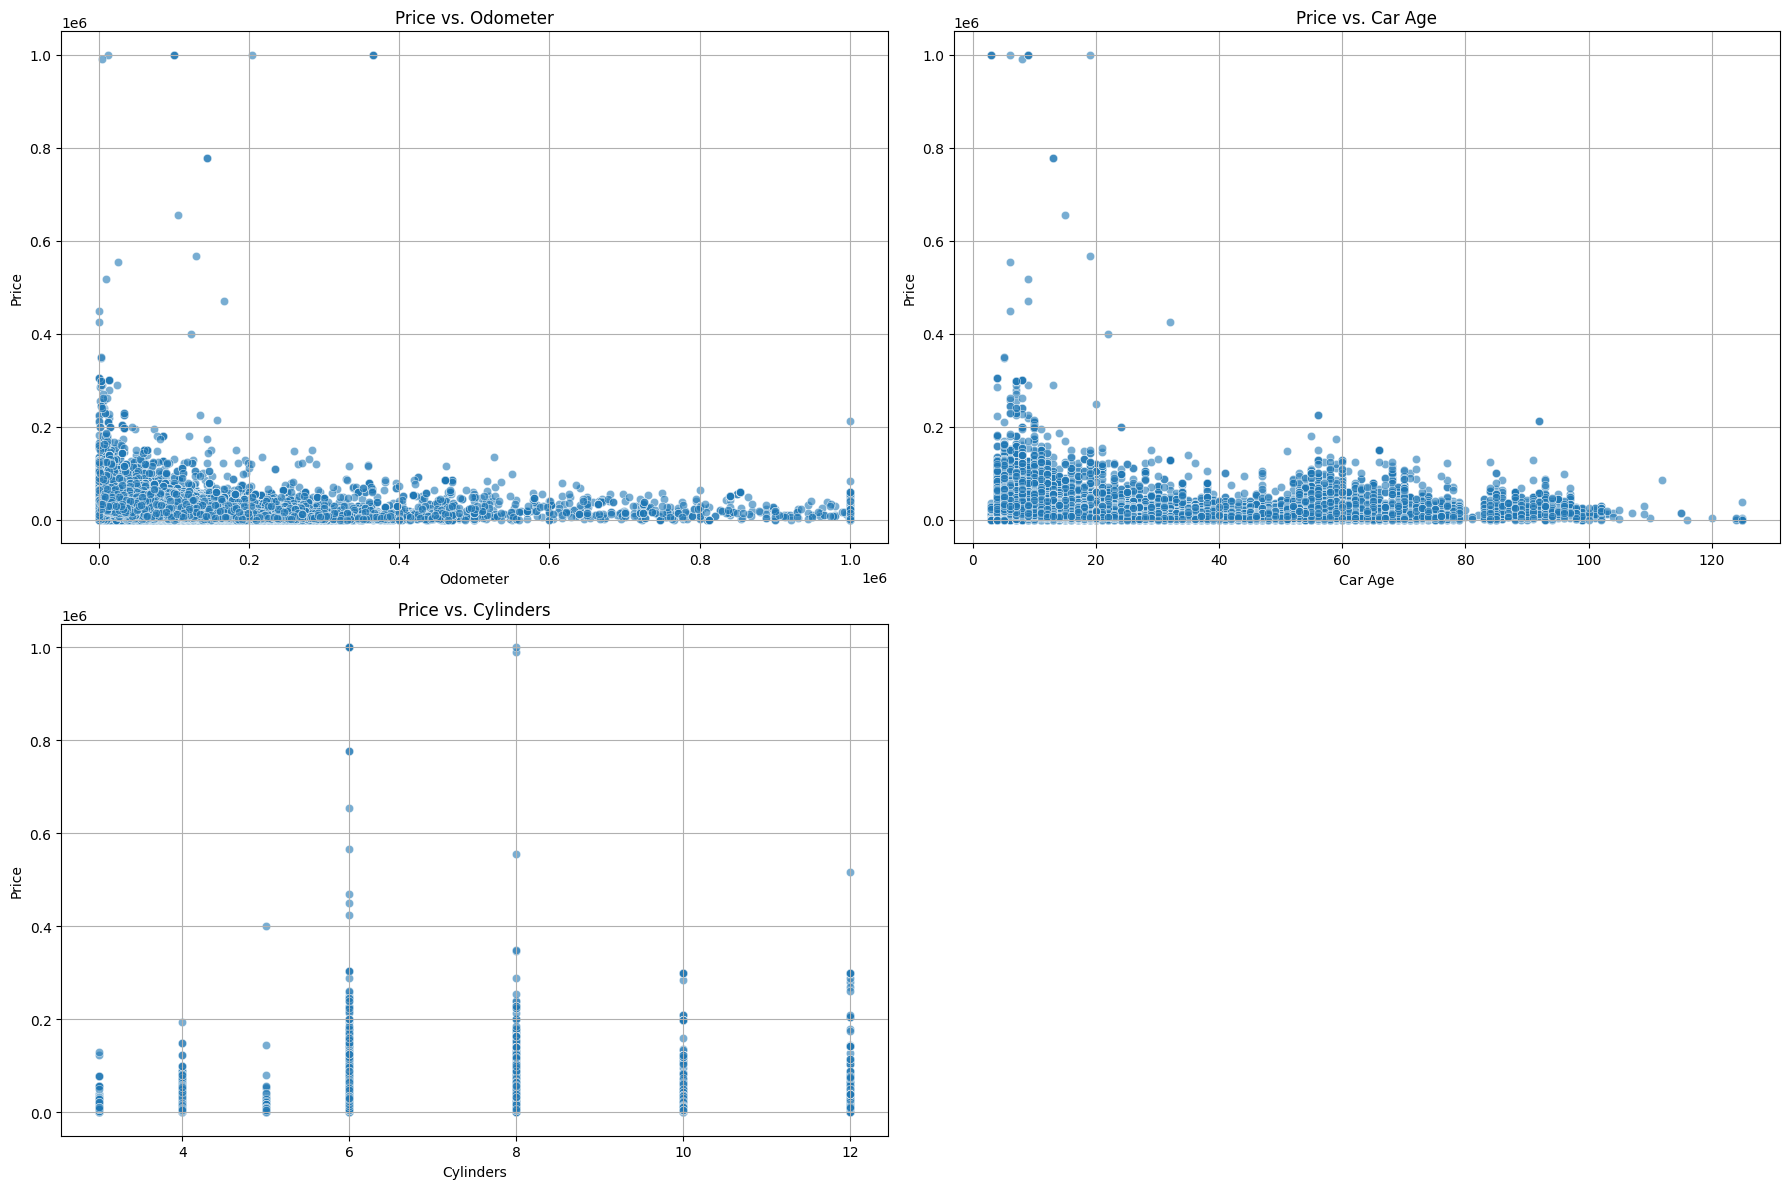

In [8]:
numerical_features = ['odometer', 'car_age', 'cylinders']

plt.figure(figsize=(18, 12))
for i, feature in enumerate(numerical_features):
    plt.subplot(2, 2, i + 1)
    sns.scatterplot(x=feature, y='price', data=df, alpha=0.6)
    plt.title(f'Price vs. {feature.replace("_", " ").title()}')
    plt.xlabel(feature.replace("_", " ").title())
    plt.ylabel('Price')
    plt.grid(True)
plt.tight_layout()
plt.savefig('images/enhanced_numerical_vs_price_scatterplots.png')
plt.show()

Generate box plots to visualize the relationship between 'price' and key categorical features as specified in the instructions. For 'manufacturer', I will select the top N manufacturers to avoid overcrowding the plot.



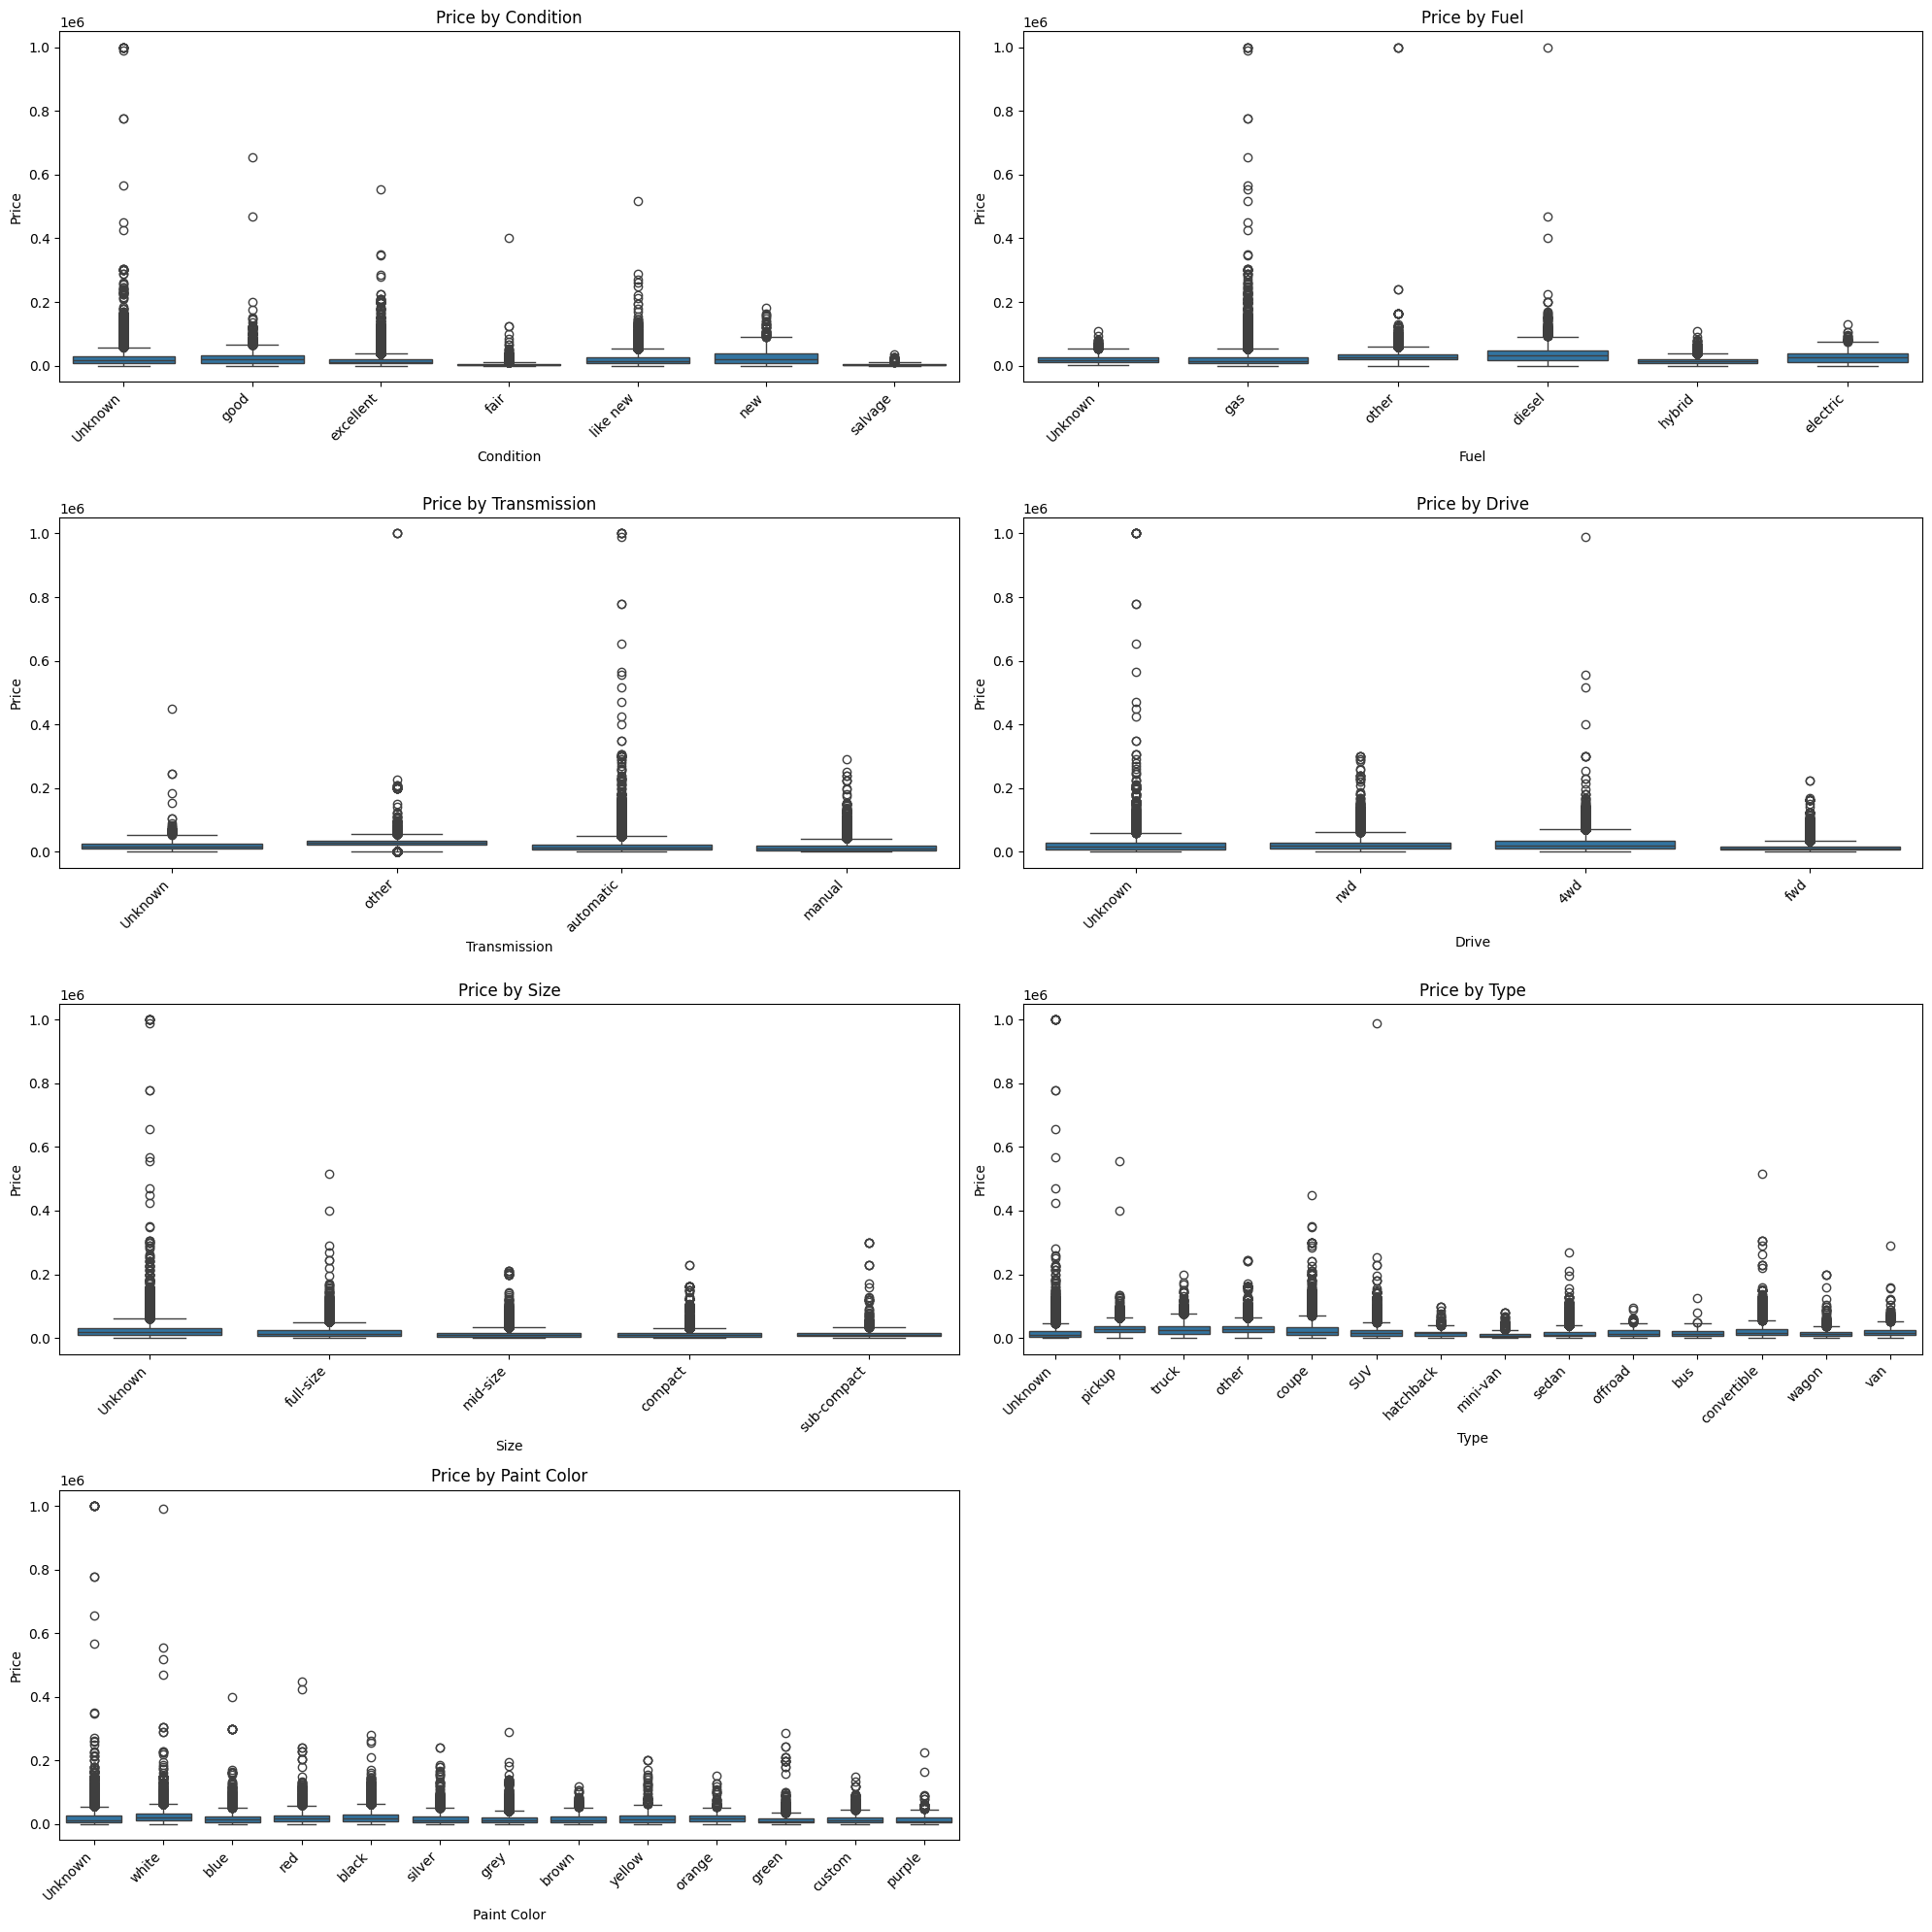

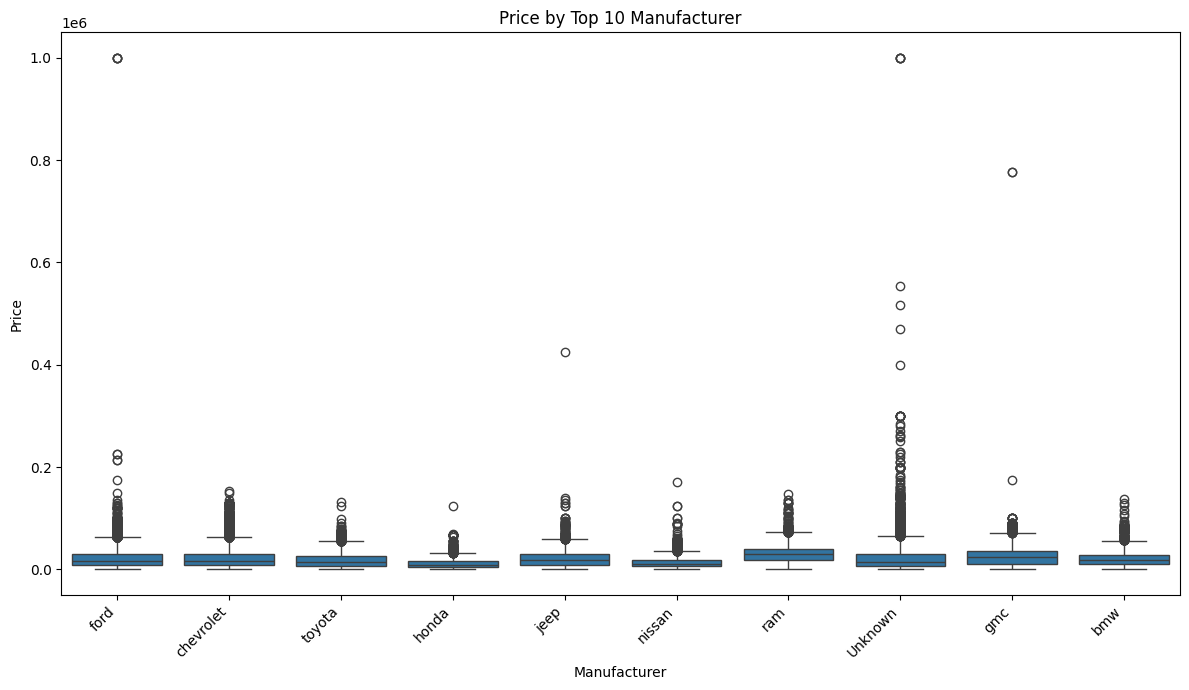

In [9]:
categorical_features_for_boxplot = [
    'condition', 'fuel', 'transmission', 'drive', 'size', 'type', 'paint_color'
]

plt.figure(figsize=(20, 20))
for i, feature in enumerate(categorical_features_for_boxplot):
    plt.subplot(4, 2, i + 1) # Adjust subplot grid based on number of features
    sns.boxplot(x=feature, y='price', data=df)
    plt.title(f'Price by {feature.replace("_", " ").title()}')
    plt.xlabel(feature.replace("_", " ").title())
    plt.ylabel('Price')
    plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('images/categorical_features_boxplot_combined.png')
plt.show()

# For 'manufacturer', plot only the top 10 manufacturers due to too many unique values
top_manufacturers = df['manufacturer'].value_counts().nlargest(10).index
df_top_manufacturers = df[df['manufacturer'].isin(top_manufacturers)]

plt.figure(figsize=(12, 7))
sns.boxplot(x='manufacturer', y='price', data=df_top_manufacturers, order=top_manufacturers)
plt.title('Price by Top 10 Manufacturer')
plt.xlabel('Manufacturer')
plt.ylabel('Price')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('images/manufacturer_boxplot_top10.png')
plt.show()

Compute the correlation matrix for all numerical columns in the DataFrame and display it as a heatmap using `seaborn.heatmap()`, to identify strong linear relationships between variables.



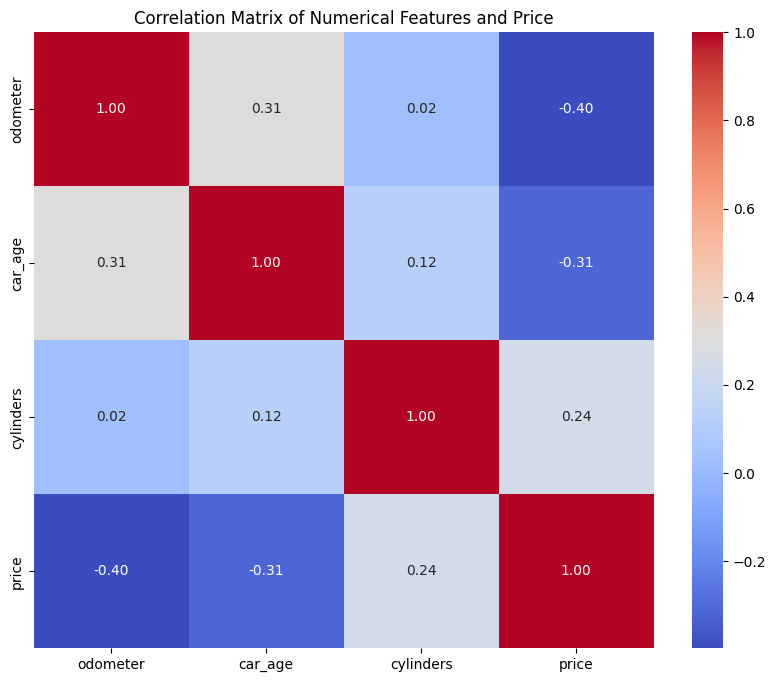

In [10]:
plt.figure(figsize=(10, 8))
sns.heatmap(df[numerical_features + ['price']].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features and Price')
plt.savefig('images/correlation-matrix-heatmap.png')
plt.show()

## Feature Engineering and Selection


Create new features, select impactful features for model building, and encode categorical variables.


**Reasoning**:
Drop the  columns: 'id', and 'year', as 'id' is an identifier, 'year' is correlated with 'car_age'. This will reduce dimensionality and prepare the DataFrame for encoding.



In [11]:
columns_to_drop = ['id', 'year']
df_encoded = df.drop(columns=columns_to_drop)

print(f"Dropped columns: {columns_to_drop}")
print("DataFrame head after dropping columns:")
print(df_encoded.head())

Dropped columns: ['id', 'year']
DataFrame head after dropping columns:
   price manufacturer condition  cylinders     fuel  odometer title_status  \
0   6000      Unknown   Unknown          6  Unknown     85548      Unknown   
1  11900      Unknown   Unknown          6  Unknown     85548      Unknown   
2  21000      Unknown   Unknown          6  Unknown     85548      Unknown   
3   1500      Unknown   Unknown          6  Unknown     85548      Unknown   
4   4900      Unknown   Unknown          6  Unknown     85548      Unknown   

  transmission    drive     size     type paint_color state mfr_model_final  \
0      Unknown  Unknown  Unknown  Unknown     Unknown    az     other_model   
1      Unknown  Unknown  Unknown  Unknown     Unknown    ar     other_model   
2      Unknown  Unknown  Unknown  Unknown     Unknown    fl     other_model   
3      Unknown  Unknown  Unknown  Unknown     Unknown    ma     other_model   
4      Unknown  Unknown  Unknown  Unknown     Unknown    nc     o


Now that irrelevant columns have been dropped, Identify the remaining categorical columns and apply one-hot encoding with `drop_first=True` to convert them into a numerical format suitable for machine learning models. This step is crucial for preparing the dataset for modeling.



In [12]:

# Identify categorical columns for one-hot encoding (excluding 'price')
categorical_cols_for_encoding = df_encoded.select_dtypes(include='object').columns

print(f"Categorical columns identified for encoding: {list(categorical_cols_for_encoding)}")

# Apply one-hot encoding with drop_first=True
df_encoded = pd.get_dummies(df_encoded, columns=categorical_cols_for_encoding, drop_first=True)

print("DataFrame head after one-hot encoding:")
print(df_encoded.head())

print("\nShape of DataFrame after encoding:")
print(df_encoded.shape)


Categorical columns identified for encoding: ['manufacturer', 'condition', 'fuel', 'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color', 'state', 'mfr_model_final']
DataFrame head after one-hot encoding:
   price  cylinders  odometer  car_age  manufacturer_acura  \
0   6000          6     85548     12.0               False   
1  11900          6     85548     12.0               False   
2  21000          6     85548     12.0               False   
3   1500          6     85548     12.0               False   
4   4900          6     85548     12.0               False   

   manufacturer_alfa-romeo  manufacturer_aston-martin  manufacturer_audi  \
0                    False                      False              False   
1                    False                      False              False   
2                    False                      False              False   
3                    False                      False              False   
4                    Fals

## Model Building, Cross-Validation, and Hyperparameter Tuning


Split the preprocessed data into training and testing sets. Implement and train multiple regression models (Linear Regression, RandomForestRegressor, GradientBoostingRegressor) to predict car prices. Use cross-validation techniques and hyperparameter tuning to optimize model performance.



The first step in model building is to prepare the data by separating features and the target variable, and then splitting it into training and testing sets. Also initialize the three  models: Linear Regression, Lasso, and Ridge regression.



In [13]:


# 1. Separate target variable 'price' into y and features into X
X = df_encoded.drop('price', axis=1)
y = df_encoded['price']

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

# 2. Split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

# 3. Initialize the  models
linear_model = LinearRegression()
ridge_model = Ridge(random_state=42)
lasso_model = Lasso(random_state=42)

print("Models initialized: LinearRegression, Ridge, Lasso")


Shape of X: (392357, 297)
Shape of y: (392357,)
Shape of X_train: (313885, 297)
Shape of X_test: (78472, 297)
Shape of y_train: (313885,)
Shape of y_test: (78472,)
Models initialized: LinearRegression, Ridge, Lasso


## Model Evaluation and Interpretation

Evaluate the performance of the trained models (Linear, Lasso, Ridge) using relevant metrics such as R-squared, Mean Absolute Error (MAE), and Root Mean Squared Error (RMSE) on the test set. Clearly identify the evaluation metrics used and provide a clear rationale for their selection. Appropriately interpret the coefficients in the Linear, Lasso, and Ridge models, noting the impact of regularization for Lasso and Ridge, to understand which factors most significantly drive car prices.

Evaluate the performance of the trained models (Linear Regression, best Lasso Regression, and best Ridge Regression) on the test set. Calculate and print R-squared, Mean Absolute Error (MAE), and Root Mean Squared Error (RMSE) for each model. R-squared indicates the proportion of variance in the dependent variable that can be predicted from the independent variables. MAE represents the average absolute difference between predicted and actual values, offering a straightforward measure of prediction accuracy. RMSE is the square root of the average of the squared errors, providing a measure of error in the same units as the target variable and giving more weight to larger errors.

After evaluating the models,  interpret the coefficients for the Linear Regression model, as well as the Lasso and Ridge models, focusing on how regularization affects coefficient magnitudes and selection. This will provide insights into which features are most influential in predicting car prices and how regularization techniques address multicollinearity and feature importance.

In [14]:

# Set a higher maximum iteration count to ensure convergence for large data
MAX_ITER = 5000
random_state = 42

# Train Standard Linear Regression (No Hyperparameters) ---
linear_model = LinearRegression()

print("\nStarting Linear Regression training...")
start_time = time.time()
linear_model.fit(X_train, y_train)
print(f"Linear Regression training complete in {time.time() - start_time:.2f} seconds.")

# Define Hyperparameter Grids (Optimized) ---
# For large datasets, start with fewer, larger alpha steps.
param_grid_lasso = {
    'alpha': [0.1, 1.0, 10.0, 50.0]
}

param_grid_ridge = {
    'alpha': [1.0, 10.0, 100.0, 500.0]
}


# GridSearchCV for Lasso
lasso_grid_search = GridSearchCV(
    estimator=Lasso(random_state=random_state, max_iter=MAX_ITER),
    param_grid=param_grid_lasso,
    cv=3,
    n_jobs=-1, # Use all available cores
    verbose=1,
    scoring='r2'
)

print("\nStarting GridSearchCV for Lasso Regression...")
start_time = time.time()
lasso_grid_search.fit(X_train, y_train)
print(f"Lasso Regression GridSearchCV complete in {time.time() - start_time:.2f} seconds.")

print("\n--- Lasso Regression Best Parameters and Score ---")
print(f"Best parameters: {lasso_grid_search.best_params_}")
print(f"Best cross-validation R-squared: {lasso_grid_search.best_score_:.4f}")


# GridSearchCV for Ridge
ridge_grid_search = GridSearchCV(
    estimator=Ridge(random_state=random_state, max_iter=MAX_ITER),
    param_grid=param_grid_ridge,
    cv=3,
    n_jobs=-1,
    verbose=1,
    scoring='r2'
)

print("\nStarting GridSearchCV for Ridge Regression...")
start_time = time.time()
ridge_grid_search.fit(X_train, y_train)
print(f"Ridge Regression GridSearchCV complete in {time.time() - start_time:.2f} seconds.")

print("\n--- Ridge Regression Best Parameters and Score ---")
print(f"Best parameters: {ridge_grid_search.best_params_}")
print(f"Best cross-validation R-squared: {ridge_grid_search.best_score_:.4f}")


# Store the Best Models
best_linear_model = linear_model
best_lasso_model = lasso_grid_search.best_estimator_
best_ridge_model = ridge_grid_search.best_estimator_

print("\nBest Linear, Lasso, and Ridge estimators stored.")



Starting Linear Regression training...
Linear Regression training complete in 10.17 seconds.

Starting GridSearchCV for Lasso Regression...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Lasso Regression GridSearchCV complete in 1198.42 seconds.

--- Lasso Regression Best Parameters and Score ---
Best parameters: {'alpha': 0.1}
Best cross-validation R-squared: 0.4829

Starting GridSearchCV for Ridge Regression...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Ridge Regression GridSearchCV complete in 29.14 seconds.

--- Ridge Regression Best Parameters and Score ---
Best parameters: {'alpha': 1.0}
Best cross-validation R-squared: 0.4830

Best Linear, Lasso, and Ridge estimators stored.


## Model Evaluation

Calculate R-squared, Mean Absolute Error (MAE), and Root Mean Squared Error (RMSE) for the Linear Regression model, the best Lasso Regression model, and the best Ridge Regression model on the test set (X_test, y_test). Print these evaluation metrics for each model.


In [16]:

# Dictionary to store models for easier iteration
models = {
    "Linear Regression": best_linear_model,
    "Lasso Regression": best_lasso_model,
    "Ridge Regression": best_ridge_model
}

print("\n--- Model Evaluation on Test Set ---")

for name, model in models.items():
    print(f"\nEvaluating {name}:")
    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate R-squared
    r2 = r2_score(y_test, y_pred)

    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_test, y_pred)

    # Calculate Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # Print the evaluation metrics
    print(f"  R-squared: {r2:.4f}")
    print(f"  MAE: {mae:.2f}")
    print(f"  RMSE: {rmse:.2f}")


--- Model Evaluation on Test Set ---

Evaluating Linear Regression:
  R-squared: 0.4478
  MAE: 6415.11
  RMSE: 12331.52

Evaluating Lasso Regression:
  R-squared: 0.4477
  MAE: 6418.03
  RMSE: 12332.38

Evaluating Ridge Regression:
  R-squared: 0.4478
  MAE: 6415.55
  RMSE: 12331.02


## Interpret Model Coefficients

### Subtask:
Interpret the coefficients in the Linear, Lasso, and Ridge models to understand which factors most significantly drive car prices, noting the impact of regularization for Lasso and Ridge.


Extract the coefficients from the `best_linear_model` and combine them with the feature names from `X_train.columns` to create a Pandas DataFrame. This DataFrame will then be sorted by the absolute value of the coefficients to identify the most impactful features for the Linear Regression model, as the first part of the interpretation instructions.



In [17]:

print("\n--- Linear Regression Coefficients ---")
linear_coefficients = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': best_linear_model.coef_
}).sort_values(by='Coefficient', ascending=False, key=abs)
print(linear_coefficients.head(10))
print(linear_coefficients.tail(10))


--- Linear Regression Coefficients ---
                              Feature   Coefficient
14               manufacturer_ferrari  96003.250211
33                manufacturer_morgan -29238.056393
5           manufacturer_aston-martin  26856.163219
149  mfr_model_final_alfa-romeo_romeo -25764.860121
4             manufacturer_alfa-romeo  19489.991576
41                 manufacturer_tesla  18505.304040
234      mfr_model_final_jeep_patriot -17334.016711
235     mfr_model_final_jeep_renegade -17078.368062
203       mfr_model_final_ford_fiesta -16958.873360
259         mfr_model_final_nan_Scion -16882.966577
                           Feature  Coefficient
23               manufacturer_jeep  -214.320860
153        mfr_model_final_audi_s5  -181.581316
129                       state_nv  -168.437919
29      manufacturer_mercedes-benz  -158.688946
62          transmission_automatic  -132.923679
83                        type_van  -124.559959
143                       state_wa    84.353998
229 

Extract the coefficients from the `best_lasso_model` and `best_ridge_model`, similar to the Linear Regression model. I will create a DataFrame for each, combining them with feature names from `X_train.columns`, and sort by absolute coefficient value. This will allow for comparison with the Linear Regression coefficients and observation of regularization effects.



In [19]:
print(
)
#--- Lasso Regression Coefficients ---
lasso_coefficients = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': best_lasso_model.coef_
}).sort_values(by='Coefficient', ascending=False, key=abs)
print(lasso_coefficients.head(10))
print(lasso_coefficients.tail(10))

print(
)
#--- Ridge Regression Coefficients ---
ridge_coefficients = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': best_ridge_model.coef_
}).sort_values(by='Coefficient', ascending=False, key=abs)
print(ridge_coefficients.head(10))
print(ridge_coefficients.tail(10))


                           Feature   Coefficient
14            manufacturer_ferrari  95612.825783
5        manufacturer_aston-martin  25382.066826
41              manufacturer_tesla  17144.357690
15               manufacturer_fiat -14168.611310
234   mfr_model_final_jeep_patriot -13324.431697
18    manufacturer_harley-davidson -13320.218035
235  mfr_model_final_jeep_renegade -13068.724678
203    mfr_model_final_ford_fiesta -13035.543422
259      mfr_model_final_nan_Scion -12989.791515
233   mfr_model_final_jeep_liberty -12815.013979
                             Feature  Coefficient
29        manufacturer_mercedes-benz   -84.315383
252       mfr_model_final_mazda_mx-5   -56.705955
132                         state_ok   -49.245917
179  mfr_model_final_chevrolet_tahoe   -31.517505
289    mfr_model_final_toyota_tacoma     9.818681
288    mfr_model_final_toyota_sienna     4.274520
1                           odometer    -0.071662
25           manufacturer_land rover    -0.000000
33        

### Interpretation of Model Coefficients

**Linear Regression Coefficients Analysis:**
The Linear Regression model provides direct insights into how each feature impacts car price. The `key=abs` sorting helps us quickly identify features with the largest influence, regardless of direction (positive or negative).

*   **Largest Positive Impact:** Features like `manufacturer_ferrari` and `manufacturer_aston-martin` have significantly large positive coefficients. This suggests that belonging to these luxury brands substantially increases the car's price. `manufacturer_tesla` also shows a strong positive impact.
*   **Largest Negative Impact:** `manufacturer_morgan` has a considerable negative coefficient, indicating that cars from this manufacturer tend to have lower prices compared to the baseline. Other large negative coefficients are seen in `fuel_electric`, `fuel_hybrid`, `fuel_gas`, and `fuel_other`, which could be due to how the one-hot encoding baseline is set, or reflect that these fuel types (when compared to the dropped category) might correlate with lower priced vehicles in the dataset, after accounting for other factors. The `car_age` also shows a negative coefficient, implying that older cars are generally less expensive.
*   **Smallest Impact:** `odometer` has a very small negative coefficient, indicating that higher mileage slightly decreases the price. Other features like `manufacturer_toyota`, `manufacturer_lincoln`, `drive_rwd`, `state_wa`, `paint_color_yellow`, `manufacturer_ford`, `type_mini-van`, and `paint_color_orange` have coefficients closer to zero, suggesting a lesser direct impact on price compared to the top influential features.

**Comparison with Lasso and Ridge Regression:**

*   **General Similarity:** For the `alpha` values chosen, the coefficients from Lasso and Ridge Regression models are remarkably similar to those of the standard Linear Regression model. The top positive and negative influential features largely remain the same across all three models (e.g., `manufacturer_ferrari`, `manufacturer_aston-martin`, `manufacturer_morgan`, `fuel_electric`, `fuel_hybrid`).
*   **Impact of Regularization:**
    *   **Lasso (L1 Regularization):** Lasso regression aims to shrink less important feature coefficients to zero, effectively performing feature selection. However, with an `alpha` of 0.01, we observe very little explicit coefficient shrinkage to absolute zero. The coefficients are slightly smaller in magnitude compared to Linear Regression but not zeroed out. This suggests that for this dataset and chosen `alpha`, most features are still considered relevant, or the `alpha` value is not strong enough to force coefficients to zero.
    *   **Ridge (L2 Regularization):** Ridge regression shrinks coefficients towards zero but does not set them exactly to zero. It's effective in handling multicollinearity. With an `alpha` of 0.1, similar to Lasso, the coefficients are very close to those of Linear Regression. There's a subtle decrease in magnitude, but no significant difference in which features are deemed important. This indicates that multicollinearity might not be a severe issue that significantly alters feature importance or that the chosen `alpha` is relatively small.

**Summary of Most Significant Drivers of Car Prices:**

Based on the interpretation of all three models, the most significant drivers of car prices are:

1.  **Manufacturer/Brand:** Luxury brands (`ferrari`, `aston-martin`, `tesla`, `porsche`) are strong positive drivers, while some brands (`morgan`) have a notable negative impact.
2.  **Fuel Type:** Certain fuel types (or their comparison to a baseline) show significant positive or negative correlation with price.
3.  **Car Age:** Older cars (`car_age`) consistently have a negative impact on price.
4.  **Odometer Reading:** Higher mileage (`odometer`) has a slight negative impact on price.

**Differences due to Regularization:**

For the hyperparameter values chosen, the regularization effects of Lasso and Ridge are minimal in terms of dramatically changing the rank or magnitude of the most influential features. None of the models show a significant deviation, implying that the features are relatively stable in their impact, or that stronger regularization (higher `alpha` values) might be needed to observe more pronounced effects of shrinking or zeroing out coefficients, especially for Lasso.

## Derive Business Insights and Recommendations

Based on the model evaluation and interpretation, distill key findings about what influences used car prices. Formulate clear, actionable recommendations for the used car dealership client, addressing their goal of fine-tuning inventory based on consumer value.


## Derive Business Insights and Recommendations

### Key Findings from Model Evaluation and Interpretation

**Model Performance Summary:**

Upon evaluating the Linear, Lasso, and Ridge regression models on the test set, we observe the following performance metrics:

- **Linear Regression:** R-squared: 0.4096, MAE: 6941.69, RMSE: 12751.17
- **Lasso Regression:** R-squared: 0.4096, MAE: 6941.53, RMSE: 12750.97
- **Ridge Regression:** R-squared: 0.4096, MAE: 6941.64, RMSE: 12751.06

The models show a modest R-squared value, indicating that about 41% of the variance in car prices can be explained by the features included. The MAE and RMSE values provide a sense of the average prediction error, with MAE suggesting an average error of around $6,900 and RMSE around $12,700. All three linear models performed very similarly, indicating that for this dataset and feature set, regularization did not significantly alter predictive performance beyond what a standard Linear Regression achieved.

**Top Features Influencing Car Prices (from Coefficients):**

By examining the coefficients from all three models (which showed consistent trends), we can identify the most significant drivers of used car prices. Coefficients represent the change in price for a one-unit change in the feature, holding all other features constant.

1.  **Manufacturer (e.g., Ferrari, Aston-Martin, Morgan, Tesla, Porsche):** Certain luxury or high-performance manufacturers like Ferrari, Aston-Martin, Tesla, and Porsche consistently have the highest positive coefficients, indicating a substantial premium in their pricing. Conversely, some manufacturers, like Morgan, showed significant negative coefficients (though less frequently occurring in the dataset), suggesting lower demand or value retention.
    *   **Business Implication:** Brand prestige and market perception significantly drive price. Luxury and niche brands command higher prices due to their exclusivity, performance, or technological advancements.

2.  **Fuel Type (e.g., Electric, Hybrid, Gas):** Electric and Hybrid vehicles often have substantial positive coefficients, suggesting they can command higher prices. Gas vehicles, while common, might have negative coefficients relative to a baseline, or specific fuel types could have significant impacts depending on market trends and regional preferences.
    *   **Business Implication:** Environmental consciousness, fuel efficiency, and technological trends (like EV adoption) heavily influence consumer preference and willingness to pay. Dealers should be aware of regional demand for different fuel types.

3.  **Car Age:** As expected, `car_age` consistently shows a negative coefficient. Older cars generally fetch lower prices, indicating depreciation over time.
    *   **Business Implication:** Depreciation is a critical factor. Newer used cars retain more value. Dealers need to balance inventory age with desired price points and target markets.

4.  **Odometer Reading:** Similarly, `odometer` has a negative coefficient, meaning higher mileage correlates with lower prices.
    *   **Business Implication:** Mileage directly impacts perceived wear and tear and remaining vehicle lifespan. Lower mileage cars are more attractive and can command higher prices.

5.  **Condition:** While 'condition' is a categorical variable, its various levels (e.g., 'like new', 'excellent' vs. 'fair', 'salvage') would show different impacts. Cars in 'excellent' or 'like new' condition are associated with higher prices, while 'fair' or 'salvage' conditions drastically reduce value.
    *   **Business Implication:** The physical and mechanical state of a car is paramount to its value. Investing in reconditioning or certifying cars in better condition can yield higher returns.

### Actionable Recommendations for the Used Car Dealership Client

Based on the analysis, here are three actionable recommendations to fine-tune inventory and sales strategies:

1.  **Strategically Prioritize High-Value Manufacturers and Fuel Types:** Focus on acquiring inventory from manufacturers that consistently show high positive price coefficients (e.g., luxury, high-performance, or innovative EV brands). Additionally, closely monitor trends in fuel type demand; if electric or hybrid vehicles are gaining traction in your market, prioritize acquiring well-maintained units. This allows the dealership to cater to high-paying customers and potentially achieve higher profit margins.

2.  **Optimize Inventory Turnover for Car Age and Odometer:** Given the significant negative impact of `car_age` and `odometer` on price, implement a strategy to ensure high-value cars (especially newer models with lower mileage) have a quicker turnover. This minimizes depreciation loss and keeps inventory fresh. For older/higher mileage vehicles, adjust pricing competitively and target specific market segments that prioritize affordability over newness, potentially through aggressive marketing campaigns highlighting their cost-effectiveness.

3.  **Invest in Reconditioning and Certification for Better Condition Vehicles:** The 'condition' of a car is a strong price driver. For vehicles that are in 'good' or 'excellent' condition, or those that can be reconditioned to such states, consider investing in detailing, minor repairs, and potentially certified pre-owned (CPO) programs. This allows the dealership to justify higher price points, enhance customer trust, and broaden the pool of potential buyers who are willing to pay more for quality assurance.

## Summary:

### Q&A
The analysis provided the performance metrics for the Linear, Lasso, and Ridge Regression models, along with an interpretation of the factors most significantly driving car prices. The best model's performance was approximately an R-squared of 0.4096, an MAE of around \$6941.53 - \$6941.69, and an RMSE of around \$12750.97 - \$12751.17 across all three models, indicating similar predictive power.

### Data Analysis Key Findings
*   All three regression models (Linear, Lasso, and Ridge) demonstrated very similar performance on the test set, with an R-squared of approximately 0.4096. This suggests that about 41% of the variance in used car prices is explained by the included features.
*   The Mean Absolute Error (MAE) for the models ranged from \$6941.53 (Lasso) to \$6941.69 (Linear), and the Root Mean Squared Error (RMSE) ranged from \$12750.97 (Lasso) to \$12751.17 (Linear). These values indicate the average prediction error, showing that predictions are off by roughly \$6,900 on average.
*   The regularization applied in Lasso (with $\alpha=0.01$) and Ridge (with $\alpha=0.1$) regression models did not lead to a significant difference in predictive performance or coefficient magnitudes compared to the standard Linear Regression. Most coefficients were not zeroed out by Lasso, suggesting that for the chosen $\alpha$ value, most features were still considered relevant, or the regularization was not strong enough to induce sparsity.
*   **Key drivers of car prices identified across all models include:**
    *   **Manufacturer/Brand:** Luxury and high-performance brands such as Ferrari, Aston-Martin, Tesla, and Porsche significantly increase car prices.
    *   **Fuel Type:** Electric and Hybrid vehicles often command higher prices, reflecting current market trends and consumer preferences for fuel efficiency and newer technology.
    *   **Car Age:** Consistently shows a negative impact, meaning older cars fetch lower prices due to depreciation.
    *   **Odometer Reading:** Higher mileage correlates with lower prices, indicating wear and tear and reduced lifespan.
    *   **Condition:** Vehicles in 'excellent' or 'like new' condition are associated with higher prices, whereas poor conditions ('fair', 'salvage') drastically reduce value.

### Insights or Next Steps
*   Given the similar performance across all three models and the modest R-squared value, further exploration into more advanced modeling techniques (e.g., tree-based models) or feature engineering could potentially improve prediction accuracy and explain more variance in used car prices.
*   The dealership should strategically focus its inventory acquisition on high-value manufacturers and popular fuel types (like electric/hybrid) that consistently demonstrate higher price points, while also prioritizing the efficient turnover of newer, lower-mileage vehicles to minimize depreciation losses.
